In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, classification_report, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [27]:
df=pd.read_csv('fake_train.csv')

In [28]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# EDA

In [29]:
df.drop('id',axis=1,inplace=True)

Dropping unwanted id column

In [31]:
df.shape

(20800, 4)

There are 20800 rows and 4 columns in the dataset

In [30]:
df.duplicated().sum()

109

109 duplicate values out of 20800

In [32]:
df.drop_duplicates(inplace=True)

Removed the duplicated values

In [33]:
df.shape

(20691, 4)

In [34]:
df['label'].value_counts()

0    10387
1    10304
Name: label, dtype: int64

The dataset is balanced

In [35]:
df.isnull().sum()

title      518
author    1932
text        39
label        0
dtype: int64

So many null values

In [36]:
df.author.replace(np.nan, 'unknown', inplace = True)

Not removing unknown authors since it can help in detecting a fake news

In [37]:
df.dropna(inplace=True)

Removing rest of the nulls

# Text Preprocessing

In [38]:
lemmatizer = WordNetLemmatizer()

In [39]:
def clean_data(text):
    text=re.sub('[^a-zA-Z]',' ',text)
    text=text.lower()
    text=word_tokenize(text)
    text=[lemmatizer.lemmatize(word) for word in text if not word in stopwords.words('english')]
    text=' '.join(text)
    return text

In [40]:
df.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [42]:
df['title'] =df['title'].apply(clean_data)
df['title']

0        house dem aide even see comey letter jason cha...
1         flynn hillary clinton big woman campus breitbart
2                                    truth might get fired
3            civilian killed single u airstrike identified
4        iranian woman jailed fictional unpublished sto...
                               ...                        
20795            rapper trump poster child white supremacy
20796    n f l playoff schedule matchup odds new york time
20797    macy said receive takeover approach hudson bay...
20798            nato russia hold parallel exercise balkan
20799                                         keep f alive
Name: title, Length: 20134, dtype: object

In [43]:
df['author'] =df['author'].apply(clean_data)
df['author']

0                               darrell lucus
1                              daniel j flynn
2                          consortiumnews com
3                             jessica purkiss
4                              howard portnoy
                         ...                 
20795                           jerome hudson
20796                        benjamin hoffman
20797    michael j de la merced rachel abrams
20798                             alex ansary
20799                           david swanson
Name: author, Length: 20134, dtype: object

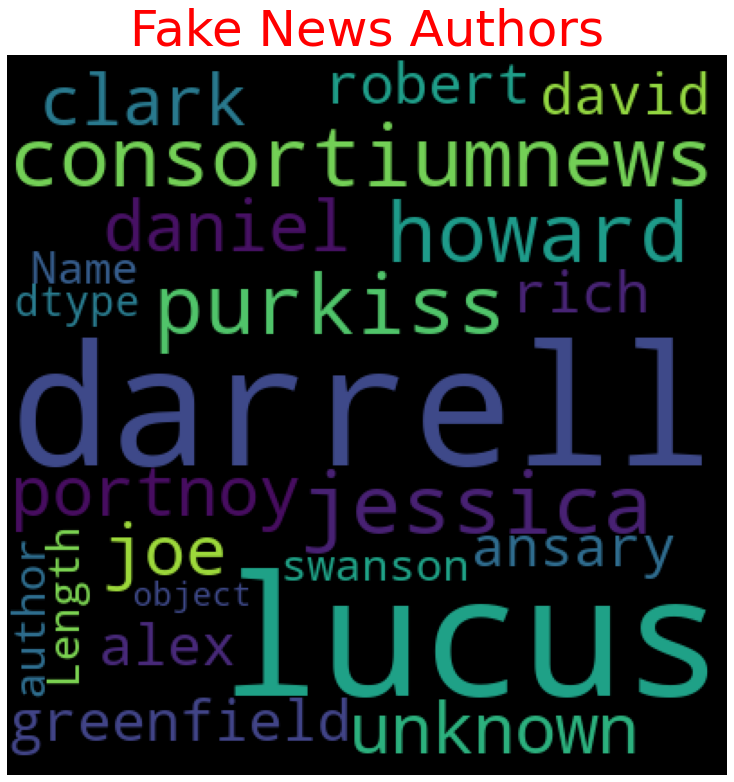

In [45]:
Fake_authors=df[(df['label']==1)]

wordcloud=WordCloud(height=400,width=400,max_words=400).generate(str(Fake_authors['author']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Fake News Authors',fontdict={'fontsize':50, 'fontweight':50, 'color':'red'})
plt.show()

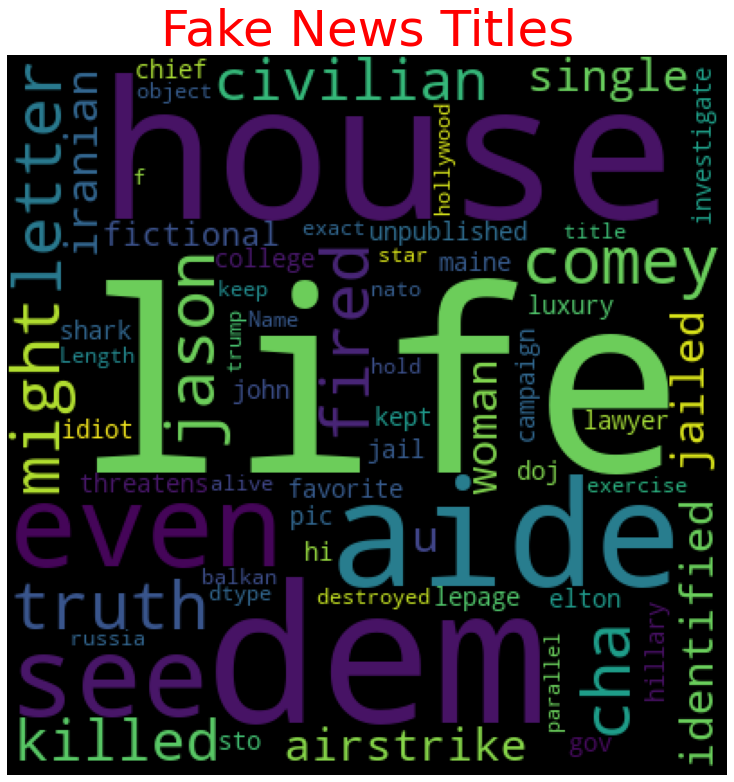

In [46]:
Fake_title=df[(df['label']==1)]

wordcloud=WordCloud(height=400,width=400,max_words=400).generate(str(Fake_title['title']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Fake News Titles',fontdict={'fontsize':50, 'fontweight':50, 'color':'red'})
plt.show()

# Model building and development

In [47]:
X=df['title']+df['author']
y=df['label']

Keeping only the title and author columns since its enough to detect fake news. The text column contains a lot of words and preprocessing on them will consume a lot of time

In [51]:
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(X)

### Finding best random state

In [52]:
maxAccu=0
maxRs=0
for i in range(1,200):
    X_train,x_test,Y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=i)
    mod=DecisionTreeClassifier()
    mod.fit(X_train,Y_train)
    pred=mod.predict(x_test)
    acc=accuracy_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRs=i
print("Best accuracy is:",maxAccu,"on Random State",maxRs)

Best accuracy is: 0.991259435836313 on Random State 134


In [53]:
X_train,x_test,Y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=134)

### Multiple model building

In [54]:
DTC=DecisionTreeClassifier()
DTC.fit(X_train,Y_train)
pred=DTC.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2540
           1       0.99      0.99      0.99      2494

    accuracy                           0.99      5034
   macro avg       0.99      0.99      0.99      5034
weighted avg       0.99      0.99      0.99      5034



In [55]:
lr=LogisticRegression()
lr.fit(X_train,Y_train)
pred=lr.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2540
           1       0.94      0.98      0.96      2494

    accuracy                           0.96      5034
   macro avg       0.96      0.96      0.96      5034
weighted avg       0.96      0.96      0.96      5034



In [56]:
RFC=RandomForestClassifier()
RFC.fit(X_train,Y_train)
pred=RFC.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2540
           1       0.97      0.99      0.98      2494

    accuracy                           0.98      5034
   macro avg       0.98      0.98      0.98      5034
weighted avg       0.98      0.98      0.98      5034



In [57]:
SV=SVC()
SV.fit(X_train,Y_train)
pred=SV.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2540
           1       0.97      0.99      0.98      2494

    accuracy                           0.98      5034
   macro avg       0.98      0.98      0.98      5034
weighted avg       0.98      0.98      0.98      5034



In [58]:
ada=AdaBoostClassifier()
ada.fit(X_train,Y_train)
pred=ada.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2540
           1       0.93      0.99      0.96      2494

    accuracy                           0.96      5034
   macro avg       0.96      0.96      0.96      5034
weighted avg       0.96      0.96      0.96      5034



In [59]:
gbr=GradientBoostingClassifier()
gbr.fit(X_train,Y_train)
pred=gbr.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      2540
           1       0.89      1.00      0.94      2494

    accuracy                           0.93      5034
   macro avg       0.94      0.94      0.93      5034
weighted avg       0.94      0.93      0.93      5034



In [60]:
knn=KNeighborsClassifier()
knn.fit(X_train,Y_train)
pred=knn.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.03      0.06      2540
           1       0.50      1.00      0.67      2494

    accuracy                           0.51      5034
   macro avg       0.75      0.52      0.36      5034
weighted avg       0.75      0.51      0.36      5034



In [61]:
import xgboost as xgb
xgb=xgb.XGBClassifier()
xgb.fit(X_train,Y_train)
pred=xgb.predict(x_test)
print(classification_report(y_test,pred))

[20:17:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2540
           1       0.97      1.00      0.98      2494

    accuracy                           0.98      5034
   macro avg       0.98      0.98      0.98      5034
weighted avg       0.98      0.98      0.98      5034



In [63]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(DTC,X,y,cv=5).mean())
print(cross_val_score(RFC,X,y,cv=5).mean())
print(cross_val_score(SV,X,y,cv=5).mean())
print(cross_val_score(lr,X,y,cv=5).mean())
print(cross_val_score(ada,X,y,cv=5).mean())
print(cross_val_score(gbr,X,y,cv=5).mean())
print(cross_val_score(knn,X,y,cv=5).mean())
print(cross_val_score(xgb,X,y,cv=5).mean())

0.9870864091623961
0.983162905233193
0.9799343625757139
0.9653819949321217
0.9584782721596931
0.9271383141440582
0.500198659051403
[22:28:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitl

###### Decision Tree gives us the best accuracy out of all the models

# Hyperparameter tuning

In [64]:
parameters={'max_features':['auto','sqrt','log2'],
            'criterion':['gini', 'entropy'],
            'max_depth':[4,5,6,7,8],
            'min_samples_split':[2,5],
            'min_samples_leaf':[1,2],
            'splitter':['best','random']}

In [66]:
dtc=DecisionTreeClassifier()
clf=GridSearchCV(dtc, parameters, cv=5)
clf.fit(X_train,Y_train)

print(clf.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}


In [67]:
Final_model=DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=2,max_features='auto',criterion='gini',max_depth=7,splitter='best')
Final_model.fit(X_train,Y_train)
pred=Final_model.predict(x_test)
acc=accuracy_score(y_test,pred)
print('Accuracy:',acc*100)

Accuracy: 80.1549463647199


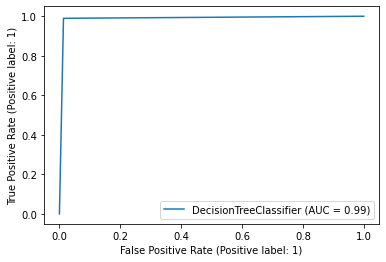

In [69]:
plot_roc_curve(DTC,x_test,y_test)
plt.show()

In [70]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [71]:
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[2514,   26],
       [  23, 2471]], dtype=int64)

In [72]:
import joblib
joblib.dump(DTC,"FinalModelFakeNews.pkl")

['FinalModelFakeNews.pkl']